# Exploring Dynamic Allocation

In [160]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import imp
import growth.model 
import growth.viz
import scipy.integrate
import tqdm
imp.reload(growth.model)
colors, palette = growth.viz.matplotlib_style()

In [164]:
# Set the constants
gamma_max = 9.65 
nu_max = 5 
Kd = 0.025

# To convert OD units
OD_CONV = 1.5E17

# Set the initial conditions
M_init = 0.01 * OD_CONV
phiR_init = growth.model.phi_R_optimal_allocation(gamma_max, nu_max, Kd)
Mr_init = phiR_init * M_init
Mp_init = (1 - phiR_init) * M_init
mu = growth.model.steady_state_mu(gamma_max, 
                                  nu_max, 
                                  phiR_init,   
                                  Kd)
cAA_init = growth.model.steady_state_cAA(gamma_max, phiR_init, nu_max, Kd) 



# Set a range of phiR 
phiR_range = list(np.linspace(0.001, 0.999, 100))
phiR_range.append(phiR_init)
# Set the integration function heavily reduced
def integrate_step(t, vars, phiR, gamma_max):
    Mr, Mp, cAA = vars
    M = Mr + Mp

    # Compute the elongation rate
    gamma = gamma_max * (cAA / (cAA + Kd))

    # Biomass dynamics
    dM_dt = gamma * Mr 

    # Precursor dynamics
    dcAA_dt = nu_max * (Mp/M) - gamma * (Mr/M) * (1 + cAA)

    # Allocation
    dMr_dt = phiR * dM_dt
    dMp_dt = (1 - phiR) * dM_dt
    return np.array([dMr_dt, dMp_dt, dcAA_dt])

# Set a time range to integrate
T_END = 0.5 
dt = 1 / 500 
time_range = np.arange(dt, T_END, dt)

In [165]:
dfs = []
for i, phi in enumerate(tqdm.tqdm(phiR_range)):
    # Sweep the integration (using odeint) over the time range
    params = [Mr_init, Mp_init, cAA_init]
    args = (phi, gamma_max)
    out = scipy.integrate.odeint(integrate_step, params, time_range, 
                                args=args, tfirst=True)
    _df = pd.DataFrame([])
    _df['Mr'] = out[:, 0]
    _df['Mp'] = out[:, 1]
    _df['cAA'] = out[:, 2]
    _df['total_biomass'] = out[:, 0] + out[:, 1]
    _df['phiR'] = phi
    _df['time'] = time_range
    dfs.append(_df)
df = pd.concat(dfs, sort=False)

100%|██████████| 101/101 [00:00<00:00, 139.35it/s]


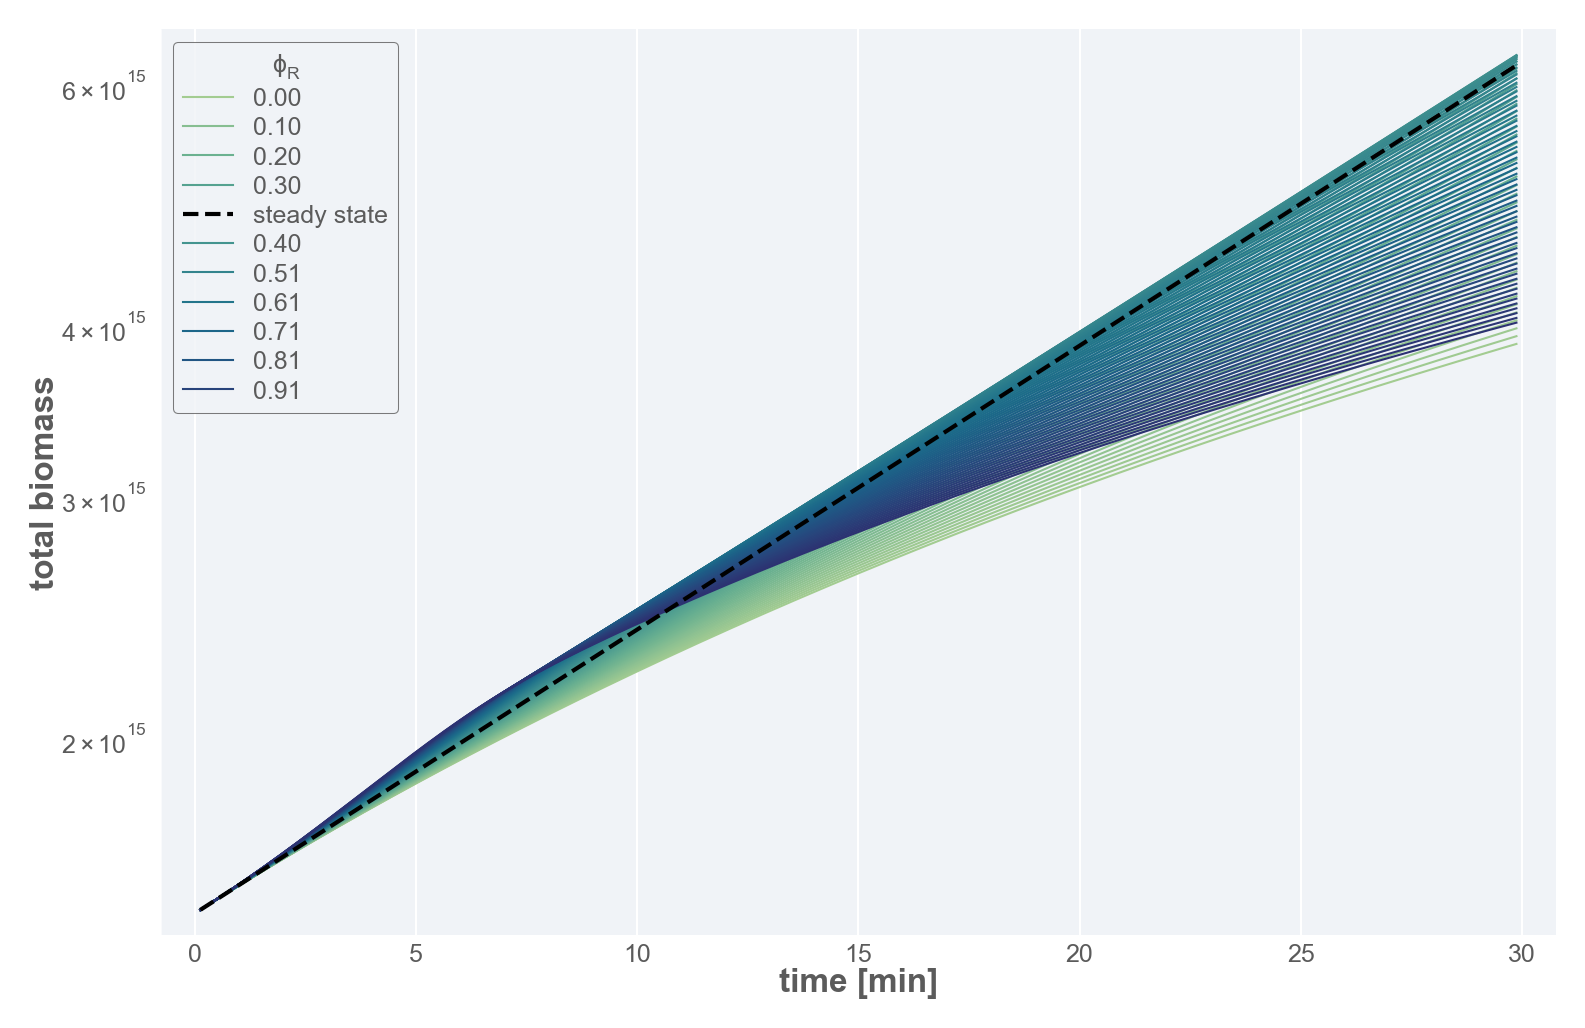

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_yscale('log')
ax.set_xlabel('time [min]')
ax.set_ylabel('total biomass')
cmap = sns.color_palette('crest', n_colors=len(phiR_range) - 1)
counter = 0
for g, d in df.groupby(['phiR']):
    if g == phiR_init:
        c = 'k'
        lw=1
        ls = '--'
        zorder = 1000
        label = 'steady state'
    else:
        c = cmap[counter]
        lw = 0.5
        ls = '-'
        zorder = 1
        if counter %10 == 0:
            label = f'{g:0.2f}' 
        else:
            label = '__nolegend__'
        counter += 1
    ax.plot(d['time'] * 60, d['total_biomass'], lw=lw,  color=c, linestyle=ls, 
            zorder=zorder, label=label)

    ax.legend(title='$\phi_R$')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


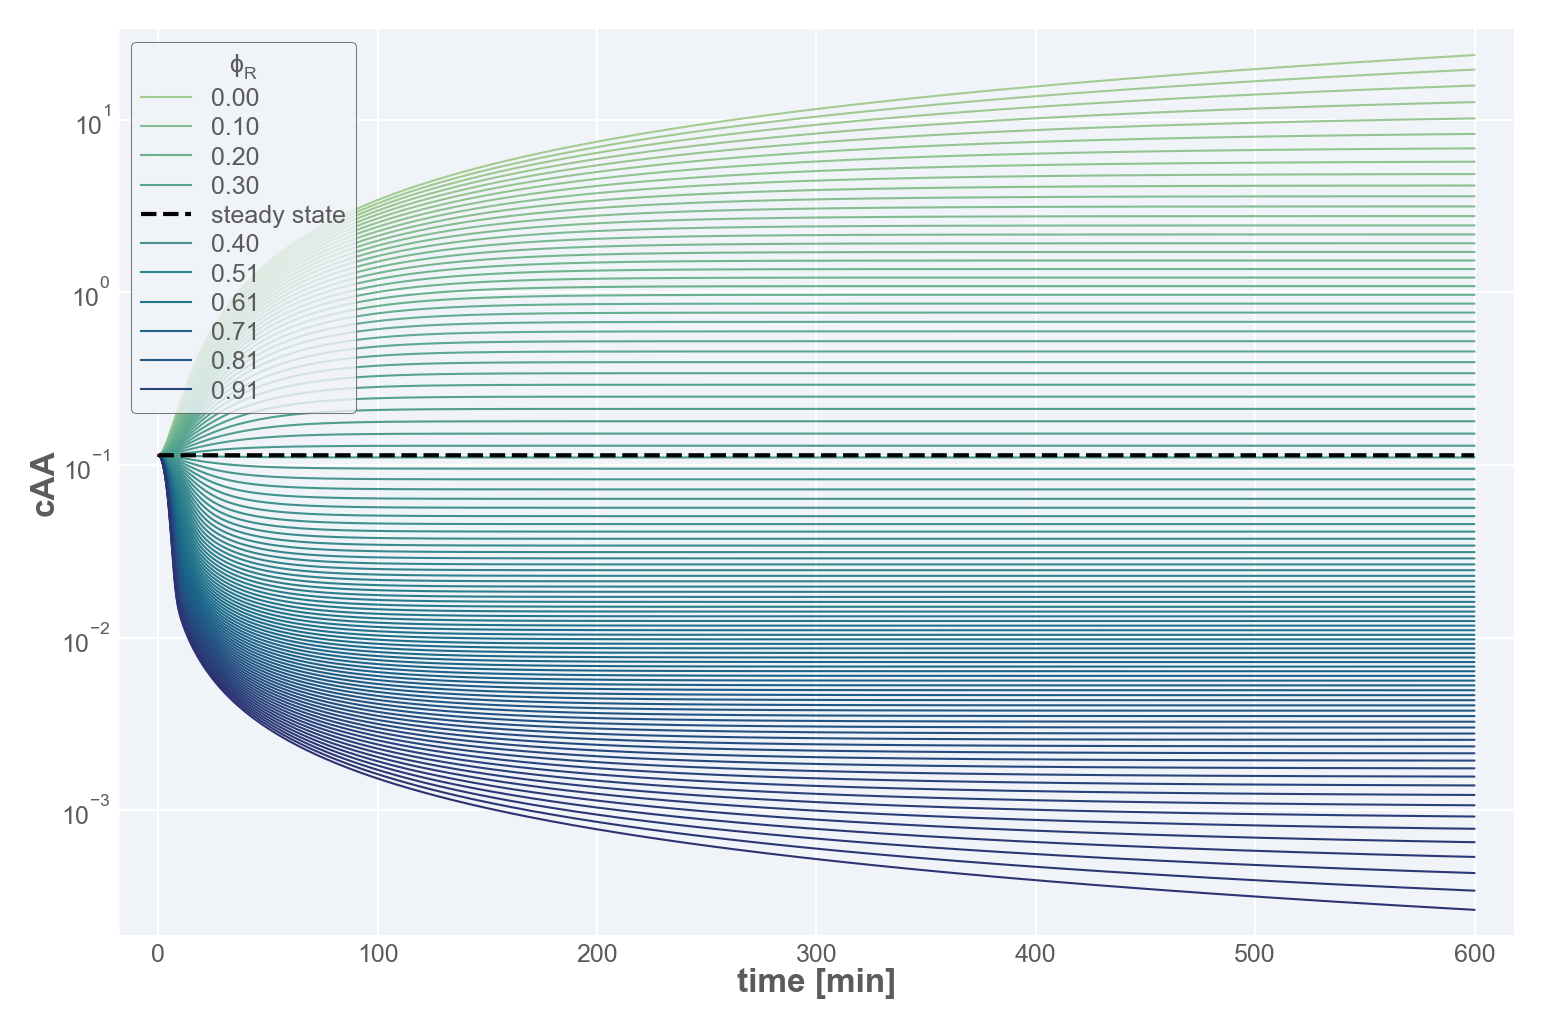

In [163]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_yscale('log')
ax.set_xlabel('time [min]')
ax.set_ylabel('cAA')
cmap = sns.color_palette('crest', n_colors=len(phiR_range) - 1)
counter = 0
for g, d in df.groupby(['phiR']):
    if g == phiR_init:
        c = 'k'
        lw=1
        ls = '--'
        zorder = 1000
        label = 'steady state'
    else:
        c = cmap[counter]
        lw = 0.5
        ls = '-'
        zorder = 1
        if counter %10 == 0:
            label = f'{g:0.2f}' 
        else:
            label = '__nolegend__'
        counter += 1
    ax.plot(d['time'] * 60, d['cAA'], color=c, lw=lw, linestyle=ls, 
            zorder=zorder, label=label)
ax.hlines(cAA_init, 0, 5, 'r')
ax.legend(title='$\phi_R$')

In [137]:
phiR_init

0.3133041732480909

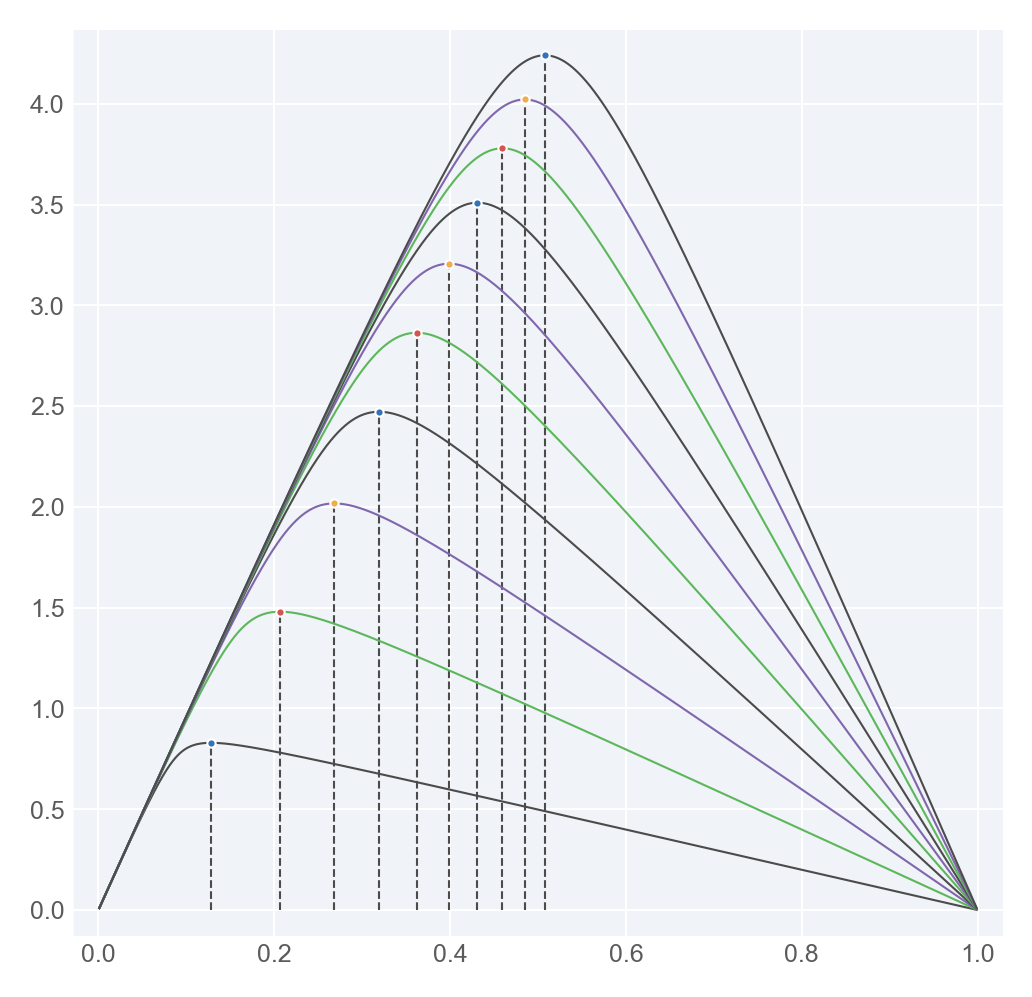

In [152]:
imp.reload(growth.model)
nu_max = np.linspace(1, 10, 10)
phiR_range = np.linspace(0.001, 0.999, 10000)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i, n in enumerate(nu_max):
    ss_mu = growth.model.steady_state_mu(gamma_max, phiR_range, n, Kd)
    ind = np.argmax(ss_mu)
    opt_phiR = growth.model.phi_R_optimal_allocation(gamma_max, n, Kd)
    opt_mu = growth.model.steady_state_mu(gamma_max, opt_phiR, n, Kd)
    ax.plot(phiR_range, ss_mu)
    ax.plot(opt_phiR, opt_mu, 'o',ms=2)
    ax.vlines(phiR_range[ind], 0, ss_mu[ind], linestyle='--')